In [178]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import nltk
nlp=spacy.load("en_core_web_lg")
pd.set_option("display.max_rows",None)
nltk.download("vader_lexicon")
nltk.download("punkt")
import re

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\25bak\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\25bak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [179]:
train=pd.read_csv("Data/train.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [180]:
test=pd.read_csv("Data/test.csv")
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [181]:
print("Null values in training set")
print(train.isnull().sum())
print("Null values in testing set")
print(test.isnull().sum())

Null values in training set
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Null values in testing set
id             0
keyword       26
location    1105
text           0
dtype: int64


In [182]:
print(train[["keyword","text"]].sample(10))

                keyword                                               text
3943              flood  Chinese rescue team arrives in Myanmar to help...
6841            trapped  Hollywood Movie About Trapped Miners Released ...
7455             wounds  It is not always friendship when kisses show u...
7612                NaN  The Latest: More Homes Razed by Northern Calif...
7007            twister  TWISTER DANCE Game  Dance Console Instructions...
6454  suicide%20bombing  Imagine a school where suicide bombing Is bein...
4783        loud%20bang  @Chibi877 --head. It hit the wall behind him w...
669               blaze  Property losses from #California wildfire near...
5260        oil%20spill  Refugio oil spill may have been costlier bigge...
7611                NaN  Police investigating after an e-bike collided ...


In [183]:
train_real=train[train["target"]==1]
train_fake=train[train["target"]==0]

In [184]:
print(train_real.shape," is the size of real train dataset")
print(train_fake.shape," is the size of fake train dataset")

(3271, 5)  is the size of real train dataset
(4342, 5)  is the size of fake train dataset


In [185]:
print(train_real["keyword"].nunique(),train_fake["keyword"].nunique())
print(test["keyword"].nunique())
print(set(train.keyword.unique())-set(test.keyword.unique()))

220 218
221
set()


In [186]:
impWords=train["keyword"].unique()[:15]
print(impWords)

[nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked']


In [187]:
# plt.figure(figsize=(15,10))
# sns.countplot(x=train["keyword"],hue=train["target"])
# plt.xticks(rotation=90)

In [188]:
unique=train["keyword"].unique().astype("str")
unique.tolist()
# uniqueCollection=[unique[i:i+15] 
#                   for i in range(0,len(unique),15)]
# plt.figure(figsize=(10,15))
# subplot_counter=1
# for group in uniqueCollection:
#     plt.figure(figsize=(10,15))
#     plt.subplot(len(uniqueCollection),1,subplot_counter)
#     countplot=sns.countplot(data=train[train["keyword"].isin(group)],x="keyword",hue="target")
#     plt.xticks(rotation=90)
#     plt.legend(title="target",loc="lower left")

['nan',
 'ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew%20up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown%20up',
 'body%20bag',
 'body%20bagging',
 'body%20bags',
 'bomb',
 'bombed',
 'bombing',
 'bridge%20collapse',
 'buildings%20burning',
 'buildings%20on%20fire',
 'burned',
 'burning',
 'burning%20buildings',
 'bush%20fires',
 'casualties',
 'casualty',
 'catastrophe',
 'catastrophic',
 'chemical%20emergency',
 'cliff%20fall',
 'collapse',
 'collapsed',
 'collide',
 'collided',
 'collision',
 'crash',
 'crashed',
 'crush',
 'crushed',
 'curfew',
 'cyclone',
 'damage',
 'danger',
 'dead',
 'death',
 'deaths',
 'debris',
 'deluge',
 'deluged',
 'demolish',
 'demolished',
 'demolition',
 'derail',
 'derailed',
 'derailment',
 'desolat

In [189]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment=SentimentIntensityAnalyzer()

In [190]:
def lastKeyIn(info):
    keyword=info[0]
    text=info[1]
    if pd.notna(keyword):
         return keyword
    doc=nlp(text)
    high_neg=0
    negative_word=None
    for word in doc:
        if word.is_stop or word.is_oov or word.is_space or word.is_punct:
             pass
        elif word.is_ascii:
            if word.text in unique or word.lemma_ in unique:
                return word
            neg=sentiment.polarity_scores(word.text)["neg"]
            if neg>high_neg:
                  high_neg=neg
                  negative_word=word
    if high_neg<0.5:
         return("Others")
    return negative_word.lower

In [191]:
print(train.isnull().sum())
train.keyword=train[["keyword","text"]].apply(lastKeyIn,axis=1)
print(train.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
id             0
keyword        0
location    2533
text           0
target         0
dtype: int64


In [192]:
keyword=train.keyword.unique().astype("str")
keyword=keyword.tolist()
keyword=set(keyword)
keyword

{'10595077177392105327',
 '1228720749737493560',
 '13773067740709375554',
 '14012806951969610844',
 '1523267725910686442',
 '7886921362353864828',
 '920492170430266568',
 'CYCLONE',
 'Damage',
 'Earthquake',
 'Evacuation',
 'FIRE',
 'Others',
 'Seismic',
 'Thunderstorm',
 'ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew%20up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown%20up',
 'body%20bag',
 'body%20bagging',
 'body%20bags',
 'bomb',
 'bombed',
 'bombing',
 'bridge%20collapse',
 'buildings%20burning',
 'buildings%20on%20fire',
 'burned',
 'burning',
 'burning%20buildings',
 'bush%20fires',
 'casualties',
 'casualty',
 'catastrophe',
 'catastrophic',
 'chemical%20emergency',
 'cliff%20fall',
 'collapse',
 'collapsed',
 'collide',
 'colli

In [193]:
train.head()

,id,keyword,location,text,target
0,1,earthquake,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,fire,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,evacuation,NaN,All residents asked to 'shelter in place' are ...,1
3,6,wildfires,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,smoke,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [194]:
countries=train.location.unique().tolist()
print(len(countries))

3342


In [195]:
print(countries[1:10])

['Birmingham', 'Est. September 2012 - Bristol', 'AFRICA', 'Philadelphia, PA', 'London, UK', 'Pretoria', 'World Wide!!', 'Paranaque City', 'Live On Webcam']


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'USA'),
  Text(1, 0, 'New York'),
  Text(2, 0, 'United States'),
  Text(3, 0, 'London'),
  Text(4, 0, 'Canada'),
  Text(5, 0, 'Nigeria'),
  Text(6, 0, 'UK'),
  Text(7, 0, 'Los Angeles, CA'),
  Text(8, 0, 'India'),
  Text(9, 0, 'Mumbai'),
  Text(10, 0, 'Washington, DC'),
  Text(11, 0, 'Kenya'),
  Text(12, 0, 'Worldwide'),
  Text(13, 0, 'Australia'),
  Text(14, 0, 'Chicago, IL')])

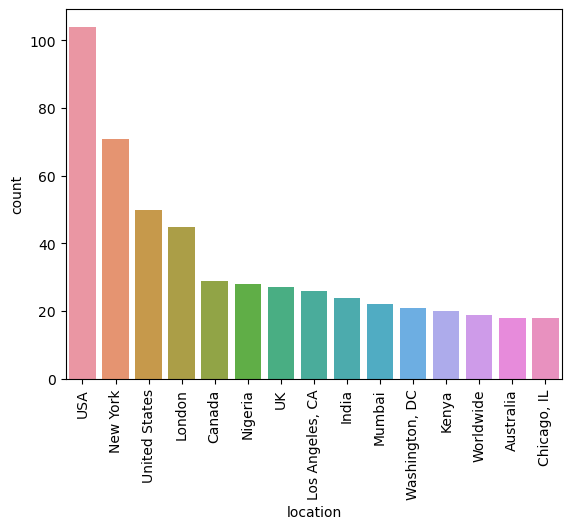

In [196]:
sns.countplot(x=train["location"],order=train.location.value_counts().iloc[:15].index)
plt.xticks(rotation=90)

In [197]:
train.head()

,id,keyword,location,text,target
0,1,earthquake,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,fire,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,evacuation,NaN,All residents asked to 'shelter in place' are ...,1
3,6,wildfires,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,smoke,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [198]:
text_to_train=train.text[3]

In [199]:
def location(cols):
    location=cols[0]
    text=cols[1]
    if pd.notna(location):
        return location
    text=nlp(text)
    for word in text.ents :
        if word.label_ in ["GPE","LOC"]:
            return word.text
    return "Others"

In [200]:
train["location"]=train[["location","text"]].apply(location,axis=1)

In [201]:
def cleanLocation(x):
    if x == 'Others':
        return 'Others'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Seattle' in x:
        return 'Seattle'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'Toronto' in x:
        return 'Toronto'
    elif 'Sacramento' in x:
        return 'Sacramento'
    elif 'Atlanta' in x:
        return 'Atlanta'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'Texas' in x:
        return 'Texas'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Indonesia' in x:
        return 'Indonesia'
    else:
        return x

In [202]:
train["location"]=train["location"].apply(cleanLocation)

In [203]:
train.head()

,id,keyword,location,text,target
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1


In [204]:
location=train.location.unique().tolist()

In [205]:
len(location)

3026

In [206]:
train.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [207]:
# def extractInformation(text):
#     hashWords=[]
#     hash_seq="#(\w+)"
#     hash_count=0
#     text=re.findall(hash_seq,text)
#     for word in text:
#         hash_count+=1  
#         hashWords.append(str(word))
#     return hashWords
# hashtagWords=extractInformation("Hi this is a beatuiful morning #hot #sunny")

In [208]:
def extractInformation(text):
    hash_seq="#(\w+)"
    text=re.findall(hash_seq,text)
    if text==[]:
        return []
    return text
hashtagWords=extractInformation("Hi this is a beatuiful morning hot sunny")

In [209]:
def hashMod(text):
    words=[]
    for word in text:
        if word in keyword:
            words.append(word)
    if words is not []:
        return words
    if text==[]:
        return("None")
    if words is []:
        return text
    

In [210]:
train["HashtagWords"]=train["text"].apply(extractInformation)
train["HashtagWords"]=train["HashtagWords"].apply(hashMod)
train["HashTagSum"]=train["HashtagWords"].apply(lambda x:len(x))

In [211]:
def joinKeywords(text):
    return " ".join(text)
train["HashtagWords"]=train["HashtagWords"].apply(joinKeywords)

In [212]:
# x=train[train["target"]==1]["text"].apply(len)
# y=train[train["target"]==0]["text"].apply(len)
# print("Average length of real tweets are ",np.average(x),"\n Average length of fake tweets are ",np.average(y))

In [213]:
def mentionSearch(text):
    pattern="@(\w+)"
    text=re.findall(pattern,text)
    if text==[]:
        return ("None")
    return " ".join(text)
train["mention"]=train["text"].apply(mentionSearch)
# train["mention"].value_counts()

In [214]:
def sentimentInput(text):
    return sentiment.polarity_scores(text)["neg"]
train["SentimentScore"]=train["text"].apply(sentimentInput)

In [215]:
# text="You should less drink water and kill more people and stab them"
# sentimentInput(text)
# sentimentZero=train[train["SentimentScore"]==0]
# sentimentZero['target'].value_counts()
# sentimentNotZero=train[train["SentimentScore"]!=0]
# sentimentNotZero["target"].value_counts()
# sentimentGreaterThan5=(train["SentimentScore"]>0.25).sum()

In [216]:
train["HashtagWords"]=train["HashtagWords"].replace("","None")

In [217]:
train.head()

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,SentimentScore
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1,earthquake,1,None,0.000
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1,None,0,None,0.286
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1,None,0,None,0.095
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1,wildfires,1,None,0.000
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1,wildfires,1,None,0.000


In [218]:
train["HashtagWords"].unique()

array(['earthquake', 'None', 'wildfires', 'flood disaster', 'flooding',
       'aftershock', 'accident', 'ambulance', 'apocalypse', 'armageddon',
       'bioterrorism', 'bombed', 'wildfire', 'casualties', 'catastrophe',
       'danger', 'dead', 'tragedy crash', 'floods', 'deluge',
       'demolished', 'survived', 'destruction', 'disaster', 'displaced',
       'drought', 'bomb', 'Earthquake', 'fire emergency rescue sirens',
       'evacuate', 'evacuation', 'fire', 'floods flooding', 'hailstorm',
       'hail hailstorm', 'hostages terrorism', 'terrorism', 'hurricane',
       'sinkhole landslide avalanche', 'landslide', 'lava', 'military',
       'disaster mudslide', 'mudslide', 'refugees', 'obliteration',
       'police', 'emergency', 'rainstorm landslide', 'drought wildfires',
       'rescued', 'seismic', 'sinkhole', 'sinking', 'storm', 'thunder',
       'Thunderstorm', 'thunder lightning thunderstorm', 'trauma',
       'survivors', 'traumatised', 'tsunami', 'whirlwind', 'fires',
      

In [219]:
def urlSearch(text):
    pattern=r"https?://t\.co/\S+"
    urls=re.findall(pattern,text)
    if urls:
        return " ".join(urls)
    else:
        return False
    

In [220]:
sample=urlSearch("Hi follow this url https://t.co/7MLMsUzV1Z")
sample

'https://t.co/7MLMsUzV1Z'

In [221]:
train["UrlCount"]=train["text"].apply(urlSearch)

In [222]:
train.sample(10)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,SentimentScore,UrlCount
6323,9039,stretcher,Others,@DareToTaha nah but thinking of getting a stre...,0,None,0,DareToTaha,0.098,False
3232,4639,emergency%20services,?????,beyond stressed beyond hysteria into the grey ...,0,None,0,None,0.336,False
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,None,0,None,0.000,http://t.co/2nndBGwyEi
4679,6653,landslide,Others,.Sink Holes Earth Slides And Avalanches&gt;&gt...,1,sinkhole landslide avalanche,3,None,0.000,https://t.co/XrRLnheLaP
2509,3603,desolation,Texas,Photoset: littlebitofbass: silinski: Ed Sheera...,0,None,0,None,0.000,http://t.co/iOsthxLcyv
1701,2456,collided,Unnamed City,@RedCoatJackpot *As it was typical for them th...,0,None,0,RedCoatJackpot,0.047,False
4560,6482,injured,Avon,@Welles_7 he was injured. He is a pro bowl back.,0,None,0,Welles_7,0.252,False
1623,2346,collapse,Mumbai,Warne shocked over Australia's epic collapse a...,1,None,0,None,0.282,http://t.co/LwwoJXtTIV
3174,4556,emergency%20plan,Reddit,http://t.co/F7LJwxJ5jp #GamerGate The end of R...,0,None,0,None,0.148,http://t.co/F7LJwxJ5jp
5774,8241,riot,San Francisco,? Cracker - White Riot ? http://t.co/Cc7D0wxk0...,0,None,0,None,0.497,http://t.co/Cc7D0wxk0M


In [223]:
def clean_text(text):
    pattern1=r"https?://t\.co/\S+"
    pattern2=r"\d+"
    pattern3=r"@\w+"
    text=re.sub(pattern1,"",text)
    text=re.sub(pattern2,"",text)
    text=re.sub(pattern3,"",text)
    return text.strip()
clean_text("Hi this si a https://t.co/7MLMsUzV1Z 8980098 @return")

'Hi this si a'

In [224]:
train["cleaned_text"]=train["text"].apply(clean_text)

In [225]:
train.head()

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,SentimentScore,UrlCount,cleaned_text
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1,earthquake,1,None,0.000,False,Our Deeds are the Reason of this #earthquake M...
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1,None,0,None,0.286,False,Forest fire near La Ronge Sask. Canada
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1,None,0,None,0.095,False,All residents asked to 'shelter in place' are ...
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1,wildfires,1,None,0.000,False,", people receive #wildfires evacuation orders ..."
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1,wildfires,1,None,0.000,False,Just got sent this photo from Ruby #Alaska as ...


In [226]:
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

def grams(text):
    n=3
    text=word_tokenize(text)
    ngramsText=ngrams(text,n)
    return [" ".join(words) for words in ngramsText]

In [227]:
train["Trigrams"]=train["text"].apply(grams)

In [228]:
train.sample(5)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,SentimentScore,UrlCount,cleaned_text,Trigrams
1186,1707,bridge%20collapse,England,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,None,0,None,0.300,http://t.co/t5TrhjUAU0,Ashes : AustraliaÛªs collapse at Trent Bridge...,"[Ashes 2015 :, 2015 : AustraliaÛªs, : Austral..."
5742,8196,riot,India,Stuart Broad Takes Eight Before Joe Root Runs ...,0,None,0,None,0.265,False,Stuart Broad Takes Eight Before Joe Root Runs ...,"[Stuart Broad Takes, Broad Takes Eight, Takes ..."
205,290,ambulance,Lesotho,What's the police or ambulance number in Lesot...,0,None,0,None,0.000,False,What's the police or ambulance number in Lesot...,"[What 's the, 's the police, the police or, po..."
1826,2625,crashed,"Victoria, Tx.",Intact+MH370+Part+Lifts+Odds+Plane+Glided+Not+...,1,None,0,YahooFinance,0.000,http://t.co/MjTN3qbgOS,Intact+MH+Part+Lifts+Odds+Plane+Glided+Not+Cra...,[Intact+MH370+Part+Lifts+Odds+Plane+Glided+Not...
6926,9934,trouble,Displaced Son of TEXAS!,ÛÏ@YMcglaun: @JulieKragt @WildWestSixGun You'...,0,None,0,YMcglaun JulieKragt WildWestSixGun,0.108,False,ÛÏ: You're a lot safer that way.Ûyeah a l...,"[ÛÏ @ YMcglaun, @ YMcglaun :, YMcglaun : @, :..."


In [229]:
train["Trigrams"]=train["Trigrams"]

In [230]:
text=train["Trigrams"][0]
text

['Our Deeds are',
 'Deeds are the',
 'are the Reason',
 'the Reason of',
 'Reason of this',
 'of this #',
 'this # earthquake',
 '# earthquake May',
 'earthquake May ALLAH',
 'May ALLAH Forgive',
 'ALLAH Forgive us',
 'Forgive us all']

In [231]:
def vectorize(text):
    vectors=[]
    for trigram in text:
        trigram=nlp(trigram)
        vectors.append(trigram.vector)  
    return vectors      

In [232]:
train.corr()["target"].drop("target").sort_values()

id                0.060781
HashTagSum        0.075032
SentimentScore    0.124187
Name: target, dtype: float64

In [233]:
train.sample(10)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,SentimentScore,UrlCount,cleaned_text,Trigrams
5229,7475,obliteration,DC Metro area,Why did God order obliteration of ancient Cana...,0,None,0,None,0.000,http://t.co/Sf2vwQvJYa,Why did God order obliteration of ancient Cana...,"[Why did God, did God order, God order obliter..."
4943,7046,meltdown,The Universe,&lt;meltdown of proportions commences I manage...,0,None,0,None,0.000,False,&lt;meltdown of proportions commences I manage...,"[& lt ;, lt ; meltdown, ; meltdown of, meltdow..."
4735,6734,lava,Venezuela,I LAVA YOU.,0,None,0,None,0.000,False,I LAVA YOU.,"[I LAVA YOU, LAVA YOU .]"
6997,10034,twister,NY,Crazy Mom Threw Teen Daughter a NUDE Twister S...,1,None,0,None,0.133,http://t.co/Hy5Pbe12TM http://t.co/c1nJpLi5oR,Crazy Mom Threw Teen Daughter a NUDE Twister S...,"[Crazy Mom Threw, Mom Threw Teen, Threw Teen D..."
4458,6341,hostages,Others,Broadcast journalism: hostages to fortune othe...,0,None,0,None,0.197,False,Broadcast journalism: hostages to fortune othe...,"[Broadcast journalism :, journalism : hostages..."
4530,6441,injured,MD,And you wonder why he's injured every year htt...,0,None,0,None,0.252,https://t.co/XYiwR9JETl,And you wonder why he's injured every year,"[And you wonder, you wonder why, wonder why he..."
1772,2545,collision,Canada,CLEARED: COLLISION: #QEW Fort Erie bound appro...,1,None,0,None,0.210,False,CLEARED: COLLISION: #QEW Fort Erie bound appro...,"[CLEARED : COLLISION, : COLLISION :, COLLISION..."
6796,9736,tragedy,Silicon Valley,@sriramk @DLin71 @pmarca Tragedy of commons pe...,0,None,0,sriramk DLin71 pmarca,0.180,False,Tragedy of commons pertains to public ownershi...,"[@ sriramk @, sriramk @ DLin71, @ DLin71 @, DL..."
3045,4372,earthquake,"Barcelona, Spain",ML 2.0 SICILY ITALY http://t.co/z6hxx6d2pm #eu...,0,None,0,None,0.000,http://t.co/z6hxx6d2pm,ML . SICILY ITALY #euroquake,"[ML 2.0 SICILY, 2.0 SICILY ITALY, SICILY ITALY..."
4777,6796,lightning,"Waverly, IA",'When you walk away\nNothing more to say\nSee ...,0,None,0,None,0.000,False,'When you walk away\nNothing more to say\nSee ...,"['When you walk, you walk away, walk away Noth..."


In [239]:
text="hello once again i am here to make work happen and once again i would like to thank you al"
def tags(text):
    text=nlp(text)
    for word in text:
        print(word.text ," ",spacy.explain(word.tag_))

In [241]:
def pos(text):
    text=nlp(text)
    oov=0
    noun=0
    adj=0
    adv=0
    verb=0
    punct=0
    det=0
    part=0
    for word in text:
        if word.pos_ == "NOUN":
            noun+=1
        elif word.is_oov:
            oov+=1
        elif word.pos_ == "ADJ":
            adj+=1
        elif word.pos_ == "ADV":
            adv+=1
        elif word.pos == "VERB":
            verb+=1
        elif word.pos_ =="PUNCT":
            punct+=1
        elif word.pos_ =="DET":
            det+=1
        elif word.pos_ =="PART":
            part+=1
    return oov,noun,adj,adv,verb,punct,det,part

In [242]:
oov,noun,adj,adv,verb,punct,det,part=pos(text)

In [246]:
train[["oov", "noun", "adj", "adv", "verb", "punct", "det", "part"]]=train["text"].apply(pos).apply(pd.Series)

In [247]:
train.sample(20)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,SentimentScore,UrlCount,cleaned_text,Trigrams,oov,noun,adj,adv,verb,punct,det,part
725,1048,bleeding,Nice places,@King_Naruto_ As long as I see Madara bleeding...,0,None,0,King_Naruto_,0.000,False,As long as I see Madara bleeding I'm good ??,"[@ King_Naruto_ As, King_Naruto_ As long, As l...",1,0,1,2,0,2,0,0
863,1245,blood,Others,Can't believe more people in their mid 20's do...,1,None,0,None,0.268,False,Can't believe more people in their mid 's don'...,"[Ca n't believe, n't believe more, believe mor...",0,6,4,0,0,2,0,3
6607,9460,terrorism,Cyprus,DireTube Information ÛÒ Egypt Cyprus and Gree...,1,None,0,None,0.000,http://t.co/V6IjxCCD2I http://t.co/YSXhFWMGOD,DireTube Information ÛÒ Egypt Cyprus and Gree...,"[DireTube Information ÛÒ, Information ÛÒ Egy...",2,3,0,0,0,0,0,0
528,763,avalanche,Others,Secrets up avalanche: catechize inner self for...,0,None,0,None,0.000,False,Secrets up avalanche: catechize inner self for...,"[Secrets up avalanche, up avalanche :, avalanc...",1,5,3,0,0,1,1,0
1752,2520,collision,"Vancouver, Colombie-Britannique",Apply now to work for Dilawri as #BODY #SHOP/C...,0,None,0,None,0.000,http://t.co/Vg7jnaH0iW http://t.co/ksHsgWGhfJ,Apply now to work for Dilawri as #BODY #SHOP/C...,"[Apply now to, now to work, to work for, work ...",2,6,1,1,0,0,0,1
66,95,ablaze,San Francisco,@ablaze what time does your talk go until? I d...,0,None,0,ablaze,0.000,False,what time does your talk go until? I don't kno...,"[@ ablaze what, ablaze what time, what time do...",1,3,0,0,0,2,1,1
3632,5181,fatalities,Washington DC,#Saudi Arabia: #Abha: Fatalities reported foll...,1,None,0,None,0.515,http://t.co/1xW0Z8ZeqW,#Saudi Arabia: #Abha: Fatalities reported foll...,"[# Saudi Arabia, Saudi Arabia :, Arabia : #, :...",1,6,0,0,0,3,0,0
2161,3101,deaths,"ÌÏT: 10.614817868480726,12.195582811791382",Bigamist and his 'first' wife are charged in t...,1,None,0,None,0.087,http://t.co/rTEuGB5Tnv,Bigamist and his 'first' wife are charged in t...,"[Bigamist and his, and his 'first, his 'first ...",2,4,3,0,0,5,1,0
3599,5139,fatal,Others,@spookyfob @feelslikefob I am okay thank you y...,0,None,0,spookyfob feelslikefob,0.116,False,I am okay thank you yes your kindness is fatal...,"[@ spookyfob @, spookyfob @ feelslikefob, @ fe...",1,5,2,0,0,1,0,0
377,542,army,JAPAN,WWI WWII JAPANESE ARMY NAVY MILITARY JAPAN LEA...,0,None,0,None,0.214,http://t.co/obfD7e4QcP http://t.co/yAZjE5OwVk,WWI WWII JAPANESE ARMY NAVY MILITARY JAPAN LEA...,"[WWI WWII JAPANESE, WWII JAPANESE ARMY, JAPANE...",3,2,2,0,0,1,0,0
